## Seasonal ARIMA mdoel on predicting airport passengers

As working in supply chain and logistics industry, time series is a common type of data to deal with. Learnt the classical ARIMA model in my undergraduate statistics programme, I would like to apply it through the executions in Python statsmodels library, on analyzing and making predictions with the time series of number of passengers using several LA airports. 

The dataset can be publicly accessed through the kaggle website:

https://www.kaggle.com/cityofLA/los-angeles-international-airport-data#los-angeles-international-airport-passenger-traffic-by-terminal.csv

The time range it presented was from 1977 to 2016 comprising of data from five airports. The time plots of the 5 time series had shown 3 out of them had comparatively higher completeness of records, and separate models would be fitted for time series of these 3 airports. I also treated different classes, domestic passengers, international passengers and total number of passengers individually.




In [0]:
!pip install pyramid-arima

In [0]:
## import data
from google.colab import files
files.upload()

In [0]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv')
df = df.iloc[:-12,:]
df.shape

(1572, 6)

In [0]:
## map month number for sorting
import calendar

Month_Rev = []
for n in range(len(df)):
  Month_Rev.append(list(calendar.month_abbr).index(df['Month'][n]))

df['Month_Rev'] = pd.Series(Month_Rev)
df.shape

(1572, 7)

In [0]:
df = df.sort_values(by=['Airport Code', 'Year', 'Month_Rev'])
df = df.reset_index(drop=True)

In [0]:
## create a datetime column
import datetime
period = []
for n in range(len(df)): 
  period.append(datetime.datetime(df['Year'][n], df['Month_Rev'][n], 1))

df['Period'] = pd.Series(period)

In [0]:
# visualize df
df.iloc[0:10,:]

Airport Code  Year Month  ...  Total Passengers  Month_Rev     Period
0          ACY  2012   Jan  ...            103048          1 2012-01-01
1          ACY  2012   Feb  ...            104309          2 2012-02-01
2          ACY  2012   Mar  ...            136490          3 2012-03-01
3          ACY  2012   Apr  ...            127344          4 2012-04-01
4          ACY  2012   May  ...            126579          5 2012-05-01
5          ACY  2012   Jun  ...            133613          6 2012-06-01
6          ACY  2012   Jul  ...            151652          7 2012-07-01
7          ACY  2012   Aug  ...            147858          8 2012-08-01
8          ACY  2012   Sep  ...             94670          9 2012-09-01
9          ACY  2012   Oct  ...             86846         10 2012-10-01

[10 rows x 8 columns]

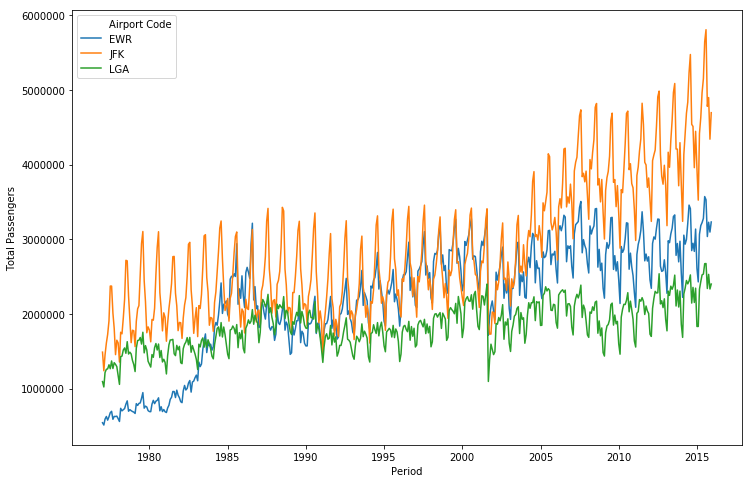

In [0]:
## plot time series by airport codes
plt.rcParams["figure.figsize"]=12,8
sb.lineplot(x='Period', y='Total Passengers', hue='Airport Code', 
            data=df[(df['Airport Code'] != 'ACY') & (df['Airport Code'] != 'SWF')])

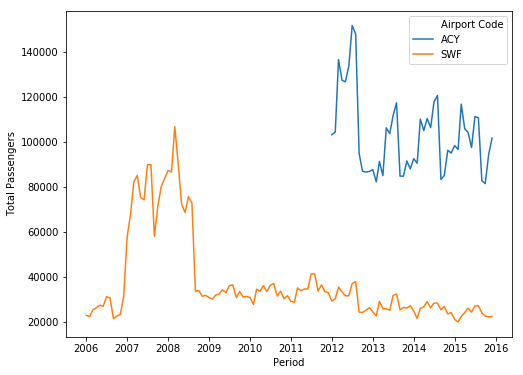

In [0]:
plt.rcParams["figure.figsize"]=8,6
sb.lineplot(x='Period', y='Total Passengers', hue='Airport Code', 
            data=df[(df['Airport Code']=='ACY') | (df['Airport Code']=='SWF')])

### Stationarity check & Differencing:

For ARIMA model, an important assumption is the time series has to be stationary. An initial check by Augmented Dickey Fuller test (a test on whether a unit root exists) showed the stationarity assumption was violated (in statsmodel library's settings, null hypothesis for AD Fuller test is stating non-stationary property). For further understanding of the trend and seasonality patterns, we could visualize the time series decomposition plots.

To get stationary time series, first differencing (non-seasonal) was taken together with the first-order seasonal differencing at a period of 12:

\begin{align}
Y_t = (Z_t - Z_{t-12}) - (Z_{t-1} - Z_{t-13})
\end{align}

Re-evaluating the decomposition plots and conducting the AD Fuller test again, all p-values showed a rejection on the null at 5% reference level, and the stationarity assumption was fulfilled. Therefore, we would be modelling the first differenced series.


In [0]:
## focus on the 3 major airports
## Non-stationary and Seasonal time series

from statsmodels.tsa.stattools import adfuller

code = ['EWR', 'JFK', 'LGA']

for x in range(3):
  for y in range(3):
    test = adfuller(df[df['Airport Code']==code[x]].iloc[:,y+3])
    print('ADF Statistic for ' + code[x] + ' - ' + df.columns[y+3] + ' : ' + str(test[0]) + ';   p-value: ' + str(test[1]))

ADF Statistic for EWR - Domestic Passengers : -2.632129953891301;   p-value: 0.08653680060733415
ADF Statistic for EWR - International Passengers : -0.2940109826372641;   p-value: 0.926348283698761
ADF Statistic for EWR - Total Passengers : -1.832373877354112;   p-value: 0.3645114946484087
ADF Statistic for JFK - Domestic Passengers : -0.049871619836999975;   p-value: 0.9542082208500817
ADF Statistic for JFK - International Passengers : 0.6796049000994527;   p-value: 0.9894219372323831
ADF Statistic for JFK - Total Passengers : 0.4584634683965683;   p-value: 0.9835544243457173
ADF Statistic for LGA - Domestic Passengers : -1.9732992135789484;   p-value: 0.29840175618735987
ADF Statistic for LGA - International Passengers : -1.5508026333483487;   p-value: 0.5082472456709628
ADF Statistic for LGA - Total Passengers : -1.7735605906508978;   p-value: 0.3936648602283216


In [0]:
df_3_airports = df[(df['Airport Code']=='EWR') | (df['Airport Code']=='JFK') | (df['Airport Code']=='LGA')].iloc[:, np.r_[0, 3:6, 7]]
df_3_airports = df_3_airports.set_index('Period')
df_3_airports

Airport Code  ...  Total Passengers
Period                   ...                  
1977-01-01          EWR  ...            541295
1977-02-01          EWR  ...            510490
1977-03-01          EWR  ...            589578
1977-04-01          EWR  ...            625022
1977-05-01          EWR  ...            576071
1977-06-01          EWR  ...            621374
1977-07-01          EWR  ...            675733
1977-08-01          EWR  ...            694595
1977-09-01          EWR  ...            587377
1977-10-01          EWR  ...            625877
1977-11-01          EWR  ...            624891
1977-12-01          EWR  ...            629348
1978-01-01          EWR  ...            596353
1978-02-01          EWR  ...            558010
1978-03-01          EWR  ...            734408
1978-04-01          EWR  ...            700659
1978-05-01          EWR  ...            715686
1978-06-01          EWR  ...            731436
1978-07-01          EWR  ...            790173
1978-08-01          EWR  ...            834387
1978-09-01          EWR  ...            695528
1978-10-01          EWR  ...            717134
1978-11-01          EWR  ...            703030
1978-12-01          EWR  ...            691678
1979-01-01          EWR  ...            683775
1979-02-01          EWR  ...            665761
1979-03-01          EWR  ...            797161
1979-04-01          EWR  ...            773171
1979-05-01          EWR  ...            800172
1979-06-01          EWR  ...            806578
...                 ...  ...               ...
2013-07-01          LGA  ...           2379680
2013-08-01          LGA  ...           2520033
2013-09-01          LGA  ...           2105957
2013-10-01          LGA  ...           2320609
2013-11-01          LGA  ...           2092298
2013-12-01          LGA  ...           2306017
2014-01-01          LGA  ...           1861037
2014-02-01          LGA  ...           1685442
2014-03-01          LGA  ...           2266651
2014-04-01          LGA  ...           2346001
2014-05-01          LGA  ...           2448007
2014-06-01          LGA  ...           2402642
2014-07-01          LGA  ...           2440633
2014-08-01          LGA  ...           2522510
2014-09-01          LGA  ...           2145122
2014-10-01          LGA  ...           2355465
2014-11-01          LGA  ...           2153415
2014-12-01          LGA  ...           2345170
2015-01-01          LGA  ...           1831802
2015-02-01          LGA  ...           1831610
2015-03-01          LGA  ...           2330616
2015-04-01          LGA  ...           2433279
2015-05-01          LGA  ...           2523355
2015-06-01          LGA  ...           2534257
2015-07-01          LGA  ...           2673089
2015-08-01          LGA  ...           2675308
2015-09-01          LGA  ...           2340430
2015-10-01          LGA  ...           2529884
2015-11-01          LGA  ...           2333555
2015-12-01          LGA  ...           2400483

[1404 rows x 4 columns]

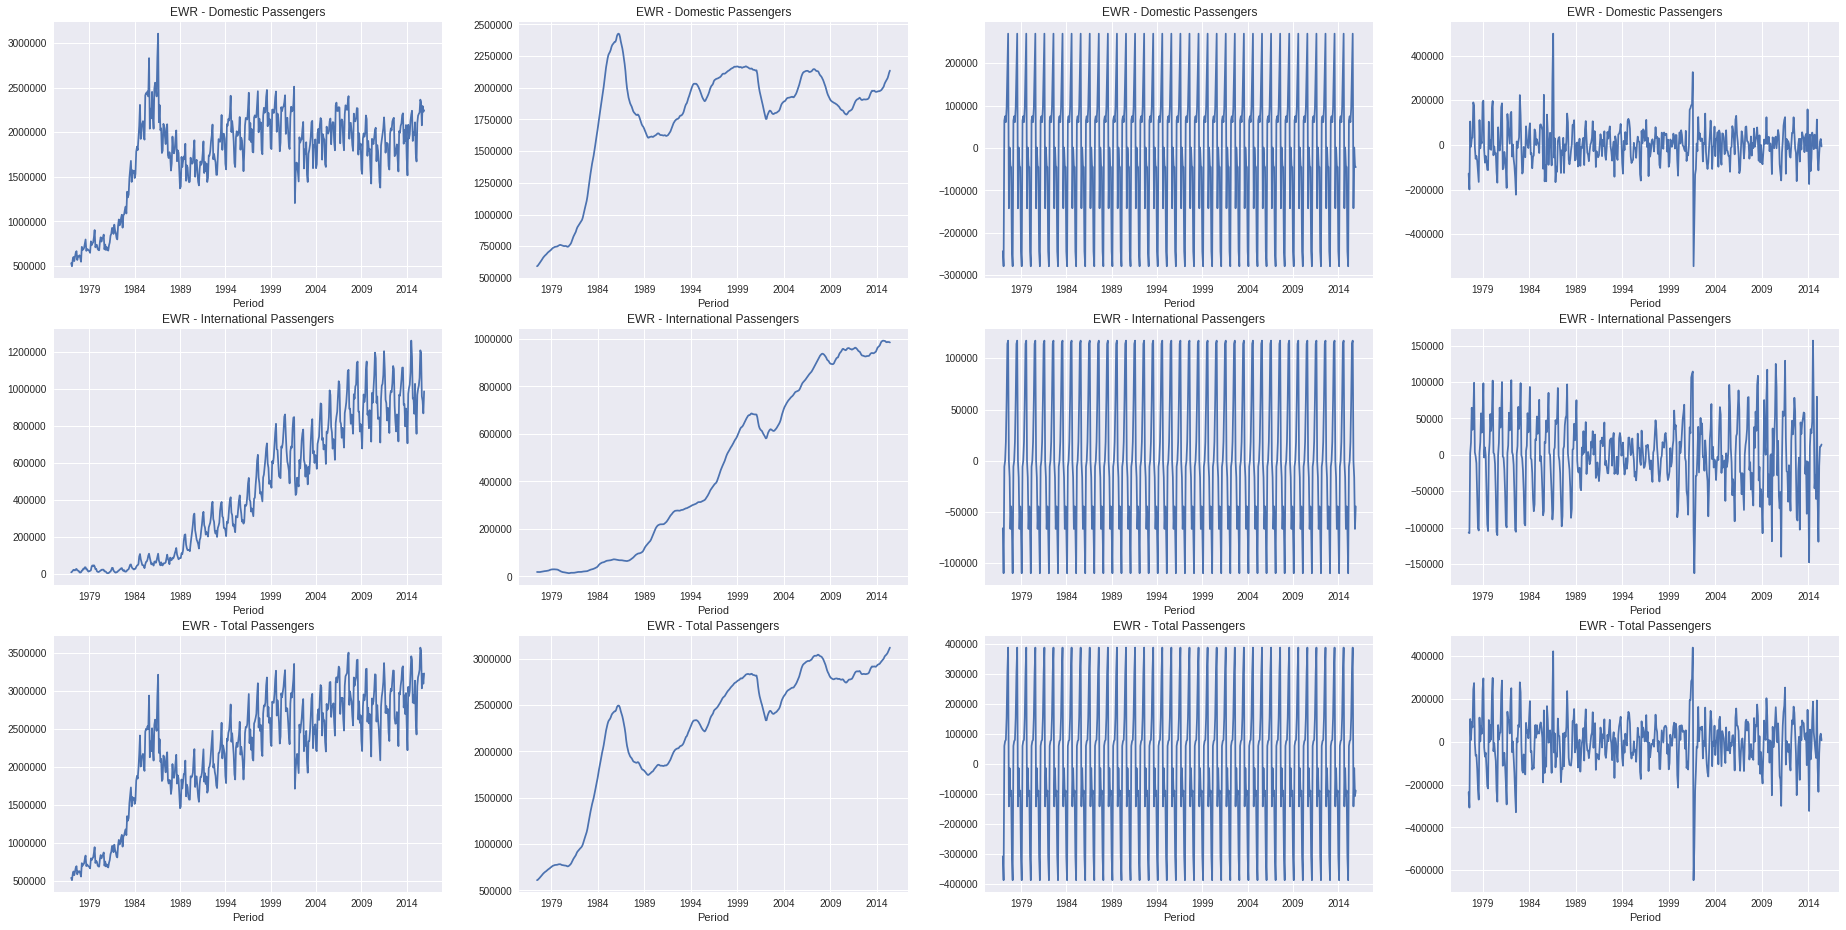

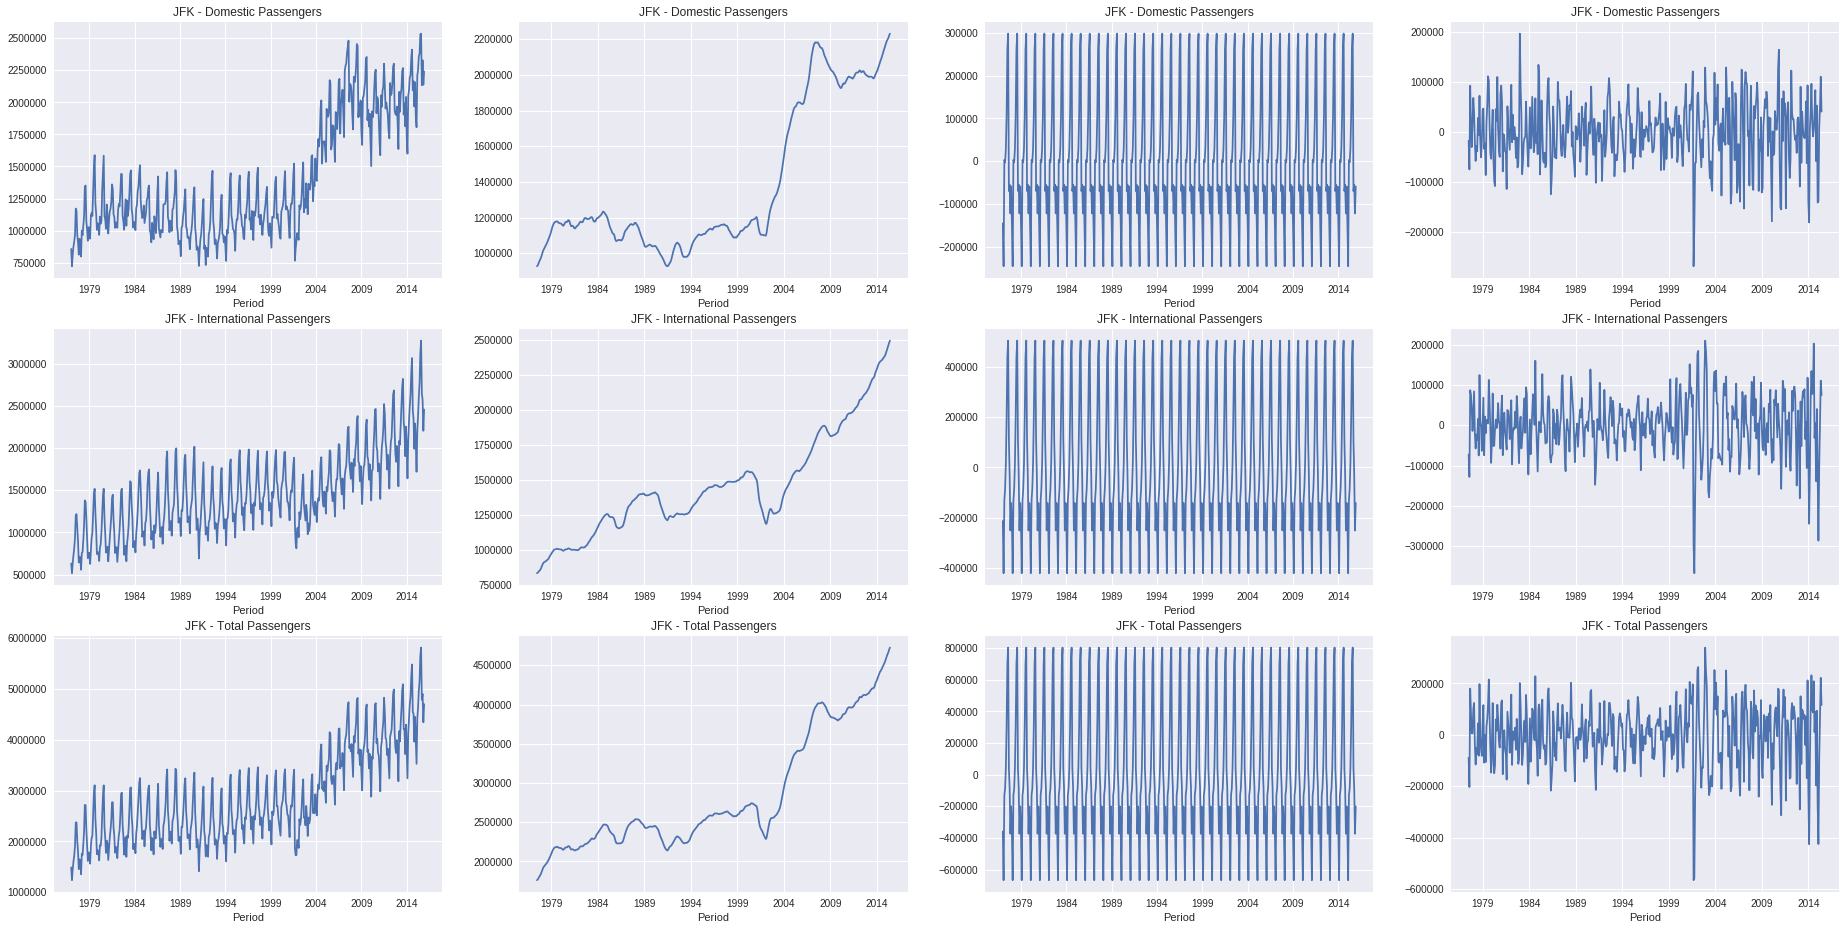

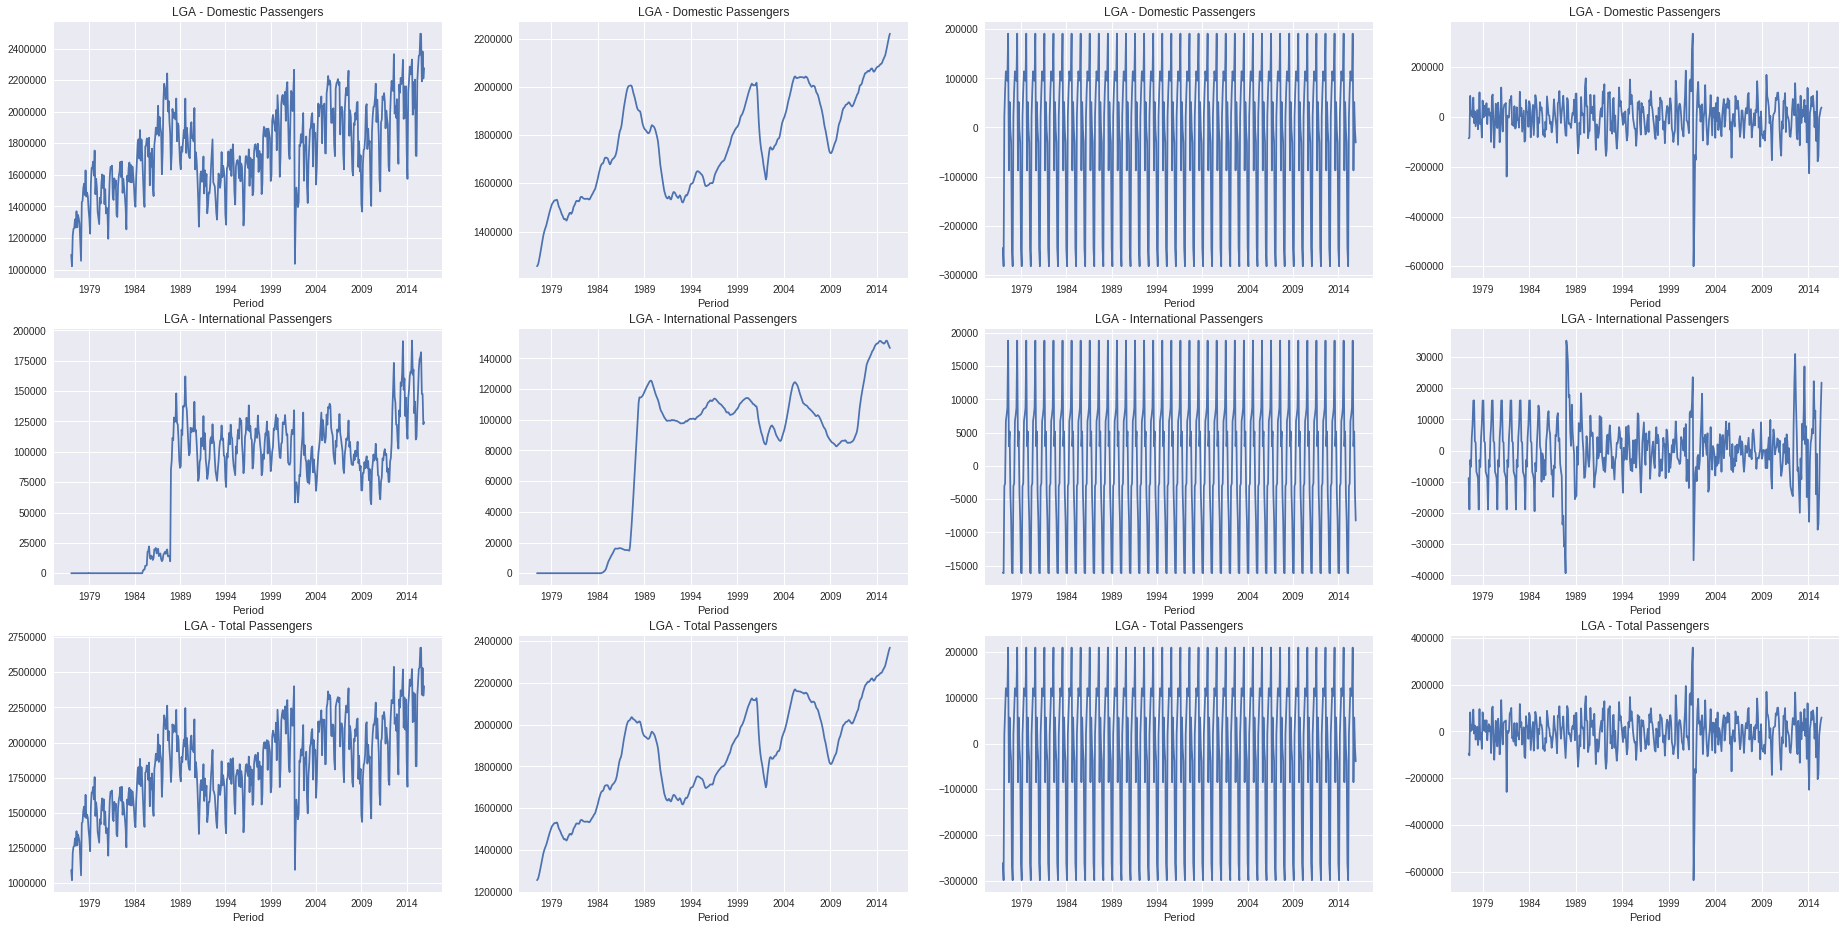

In [0]:
## Details / Breakdowns of Domestic + International + Total Passengers for the 3 airports
## Plots show the observed data, smoothed trend, seasonal index, and residuals from smoothed trend-line

from statsmodels.tsa.seasonal import seasonal_decompose

def decomposed_plot(dec, obj, attr, ax):
  dec.observed.plot(ax=ax[0], legend=False)
  ax[0].set_title(str(obj) + " - " + str(attr))
  dec.trend.plot(ax=ax[1], legend=False)
  ax[1].set_title(str(obj) + " - " + str(attr))
  dec.seasonal.plot(ax=ax[2], legend=False)
  ax[2].set_title(str(obj) + " - " + str(attr))
  dec.resid.plot(ax=ax[3], legend=False)
  ax[3].set_title(str(obj) + " - " + str(attr))

for i in range(3):
  fig, axes = plt.subplots(ncols=4, nrows=3, figsize = (32, 16))
  for j in range(3):
    decomposition = seasonal_decompose(df_3_airports[df_3_airports['Airport Code']==code[i]].iloc[:,j+1])
    decomposed_plot(decomposition, code[i], df_3_airports.columns[j+1], ax=axes[j,:])


In [0]:
df_ewr = df[df['Airport Code']=='EWR'].iloc[:, np.r_[0, 3:6, 7]]
df_ewr = df_ewr.set_index('Period')
df_jfk = df[df['Airport Code']=='JFK'].iloc[:, np.r_[0, 3:6, 7]]
df_jfk = df_jfk.set_index('Period')
df_lga = df[df['Airport Code']=='LGA'].iloc[:, np.r_[0, 3:6, 7]]
df_lga = df_lga.set_index('Period')

In [0]:
## Take first-order trend differencing and seasonal differencing
from statsmodels.tsa.statespace.tools import diff

def take_diff(s):
  value = pd.Series(diff(s, k_diff=1, k_seasonal_diff=1, seasonal_periods=12))
  return value

def take_diff_for_3_types_of_passengers(data):
  data['Domestic_diff_1'] = take_diff(data['Domestic Passengers'])
  data['International_diff_1'] = take_diff(data['International Passengers'])
  data['Total_diff_1'] = take_diff(data['Total Passengers'])
  return data

df_ewr = take_diff_for_3_types_of_passengers(df_ewr)
df_jfk = take_diff_for_3_types_of_passengers(df_jfk)
df_lga = take_diff_for_3_types_of_passengers(df_lga)

In [0]:
df_3_airports = pd.concat([df_ewr, df_jfk, df_lga], axis=0).dropna()
df_3_airports

Airport Code  ...  Total_diff_1
Period                   ...              
1978-02-01          EWR  ...       -7538.0
1978-03-01          EWR  ...       97310.0
1978-04-01          EWR  ...      -69193.0
1978-05-01          EWR  ...       63978.0
1978-06-01          EWR  ...      -29553.0
1978-07-01          EWR  ...        4378.0
1978-08-01          EWR  ...       25352.0
1978-09-01          EWR  ...      -31641.0
1978-10-01          EWR  ...      -16894.0
1978-11-01          EWR  ...      -13118.0
1978-12-01          EWR  ...      -15809.0
1979-01-01          EWR  ...       25092.0
1979-02-01          EWR  ...       20329.0
1979-03-01          EWR  ...      -44998.0
1979-04-01          EWR  ...        9759.0
1979-05-01          EWR  ...       11974.0
1979-06-01          EWR  ...       -9344.0
1979-07-01          EWR  ...        3017.0
1979-08-01          EWR  ...       32685.0
1979-09-01          EWR  ...      -69731.0
1979-10-01          EWR  ...        5766.0
1979-11-01          EWR  ...        1940.0
1979-12-01          EWR  ...      -36439.0
1980-01-01          EWR  ...       -5198.0
1980-02-01          EWR  ...       16355.0
1980-03-01          EWR  ...      -30479.0
1980-04-01          EWR  ...       75383.0
1980-05-01          EWR  ...      -71172.0
1980-06-01          EWR  ...       26963.0
1980-07-01          EWR  ...      -51568.0
...                 ...  ...           ...
2013-07-01          LGA  ...       46567.0
2013-08-01          LGA  ...     -114995.0
2013-09-01          LGA  ...       -9123.0
2013-10-01          LGA  ...      172003.0
2013-11-01          LGA  ...     -136846.0
2013-12-01          LGA  ...       95942.0
2014-01-01          LGA  ...     -169952.0
2014-02-01          LGA  ...      -21166.0
2014-03-01          LGA  ...       48101.0
2014-04-01          LGA  ...      137117.0
2014-05-01          LGA  ...      -21634.0
2014-06-01          LGA  ...       -3907.0
2014-07-01          LGA  ...      -11312.0
2014-08-01          LGA  ...      -58476.0
2014-09-01          LGA  ...       36688.0
2014-10-01          LGA  ...       -4309.0
2014-11-01          LGA  ...       26261.0
2014-12-01          LGA  ...      -21964.0
2015-01-01          LGA  ...      -68388.0
2015-02-01          LGA  ...      175403.0
2015-03-01          LGA  ...      -82203.0
2015-04-01          LGA  ...       23313.0
2015-05-01          LGA  ...      -11930.0
2015-06-01          LGA  ...       56267.0
2015-07-01          LGA  ...      100841.0
2015-08-01          LGA  ...      -79658.0
2015-09-01          LGA  ...       42510.0
2015-10-01          LGA  ...      -20889.0
2015-11-01          LGA  ...        5721.0
2015-12-01          LGA  ...     -124827.0

[1365 rows x 7 columns]

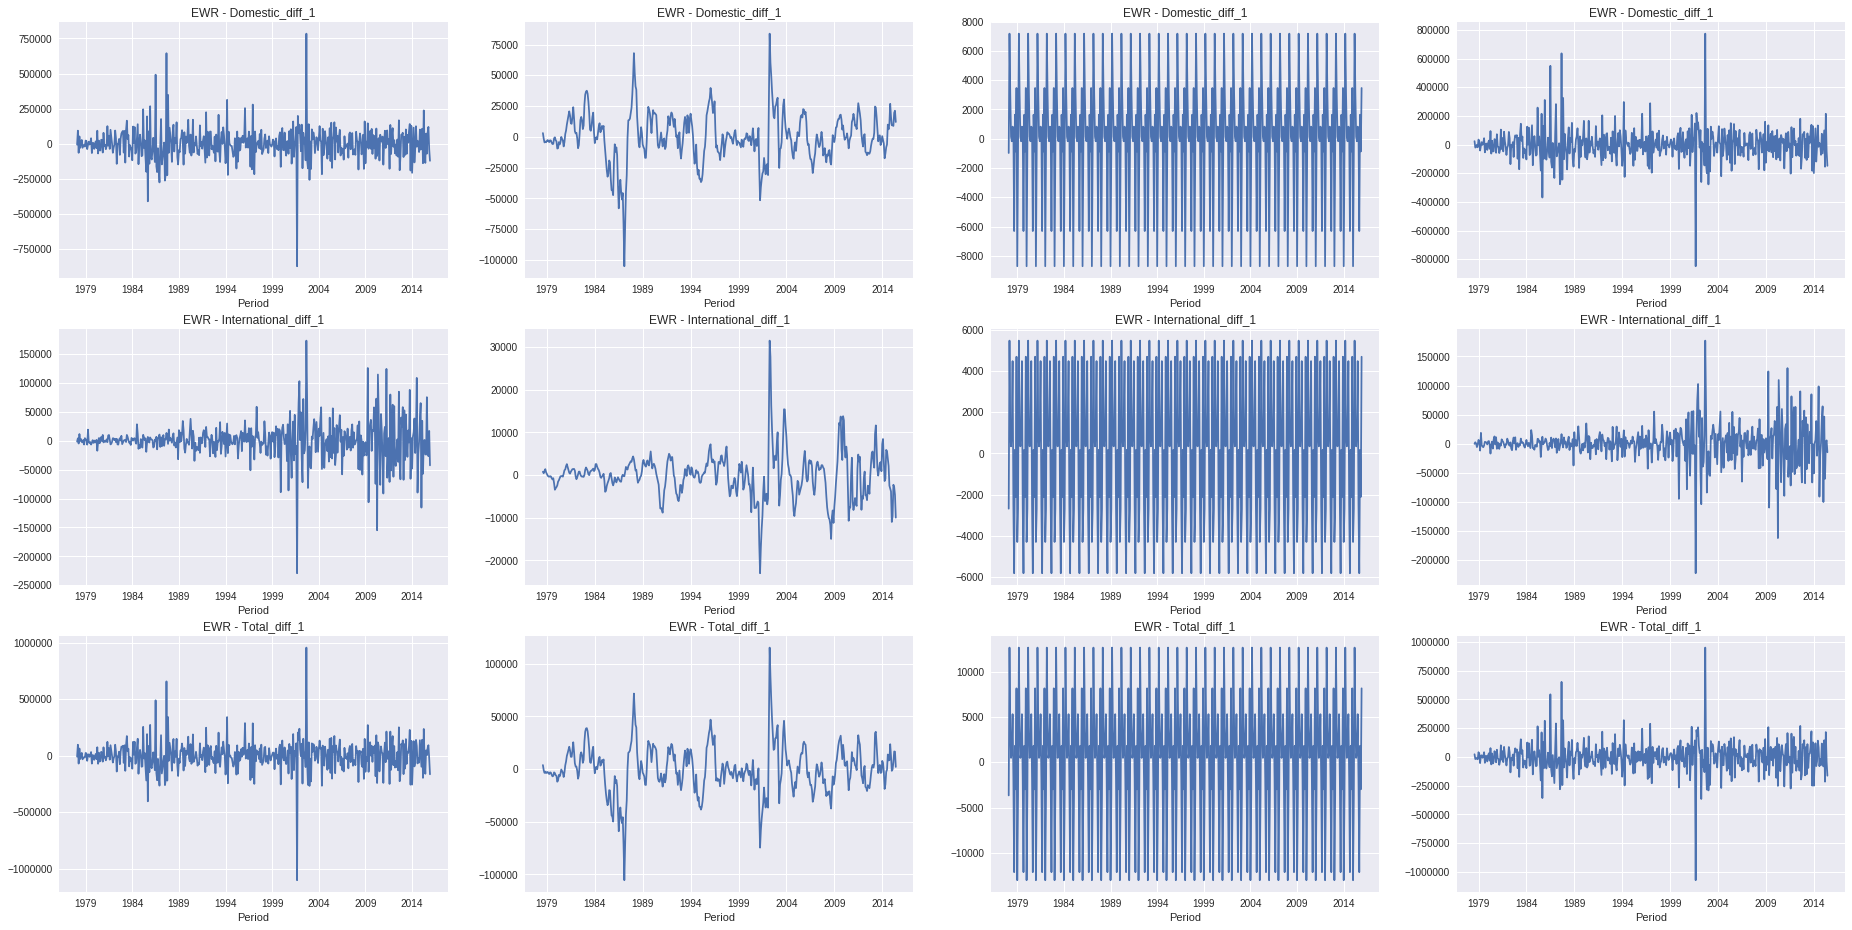

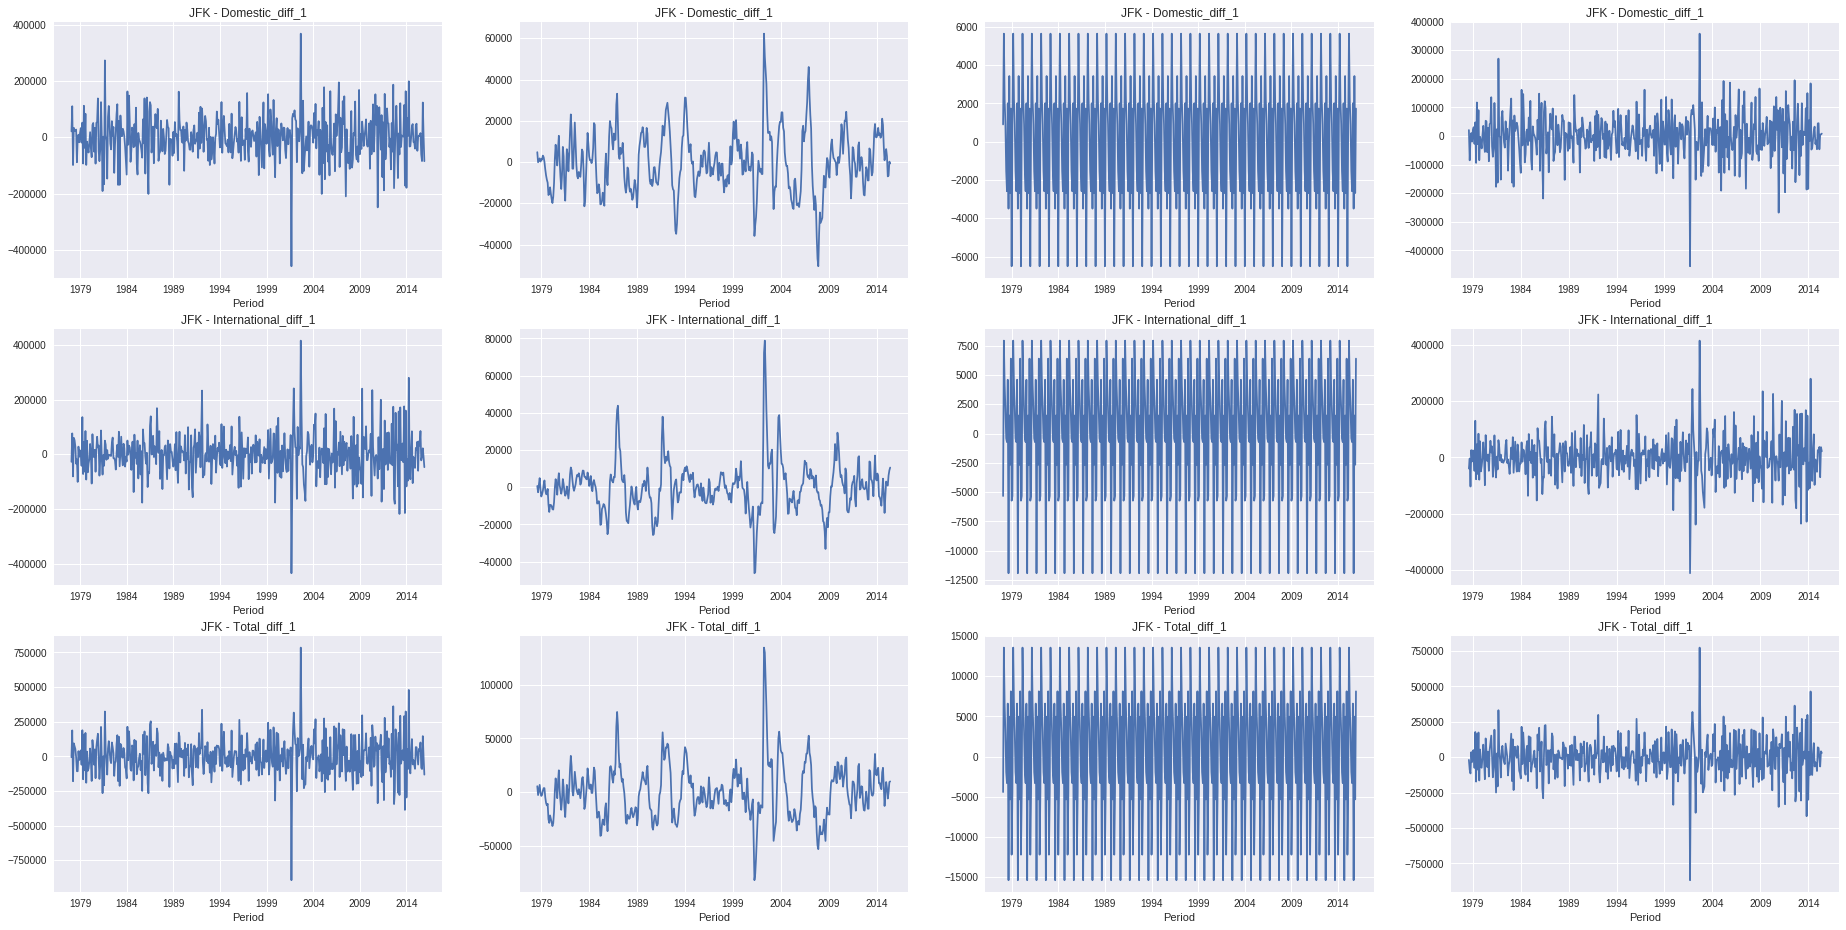

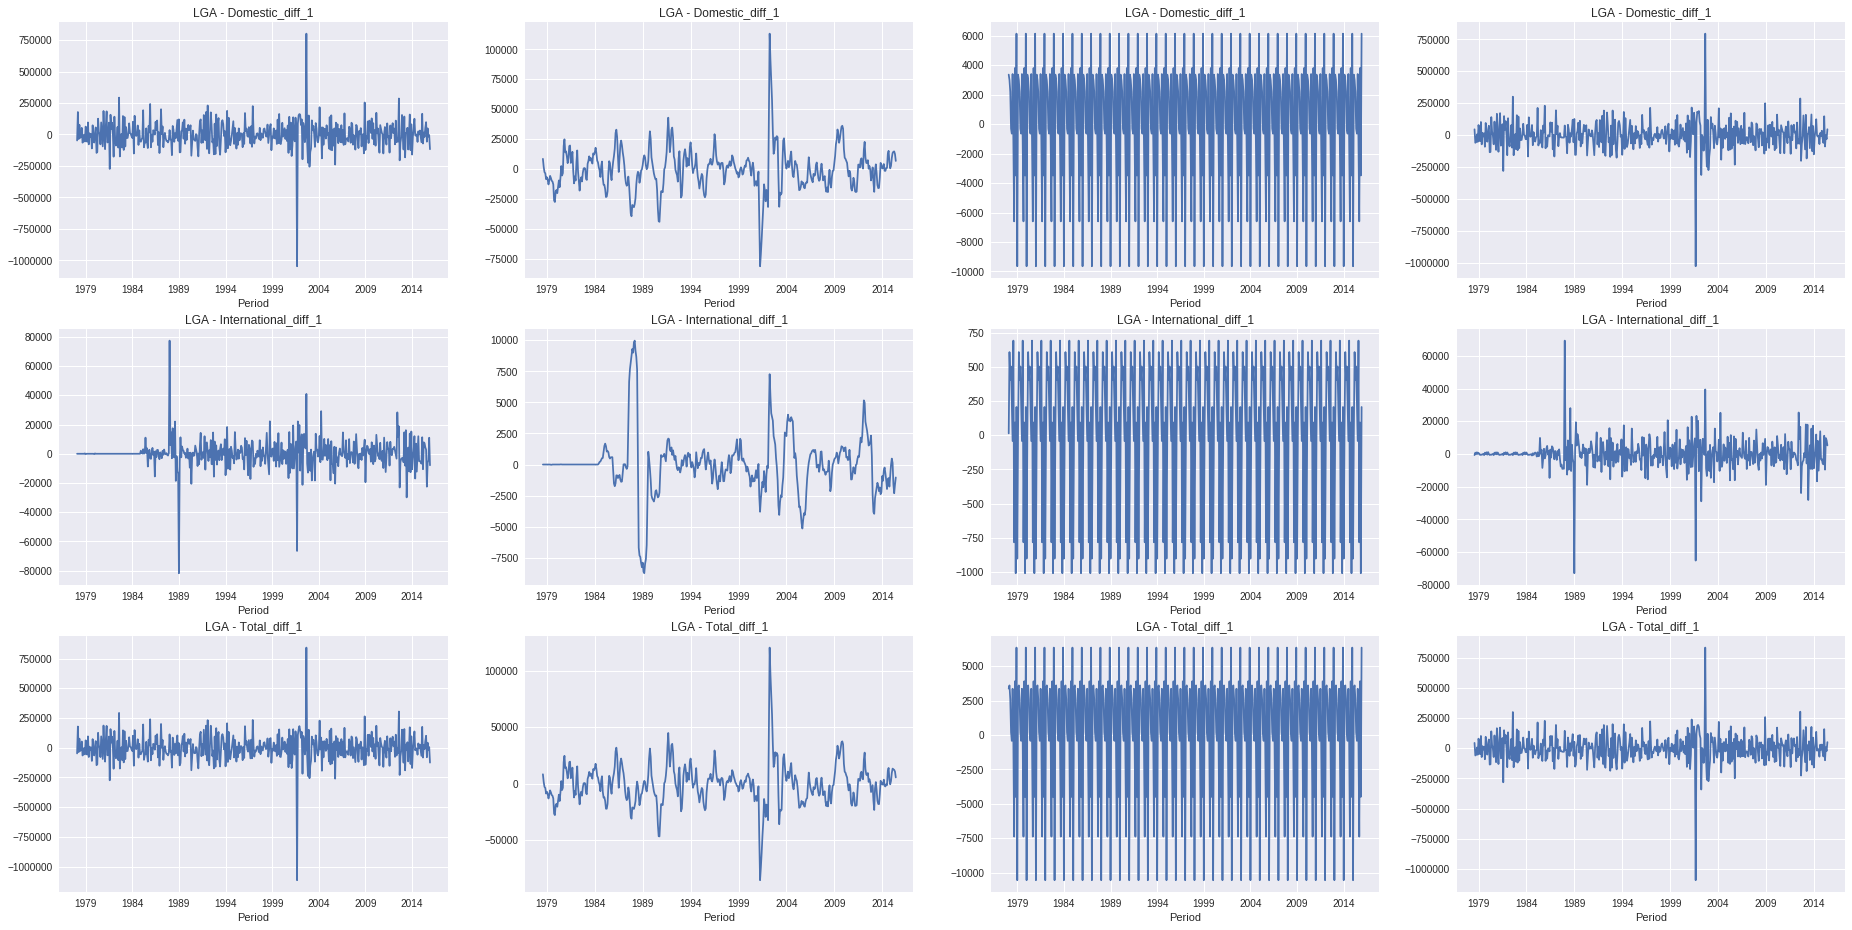

In [0]:
## RE-diagnosis of decompostion
for i in range(3):
  fig, axes = plt.subplots(ncols=4, nrows=3, figsize = (32, 16))
  for j in range(3):
    decomposition = seasonal_decompose(df_3_airports[df_3_airports['Airport Code']==code[i]].iloc[:,j+4])
    decomposed_plot(decomposition, code[i], df_3_airports.columns[j+4], ax=axes[j,:])

In [0]:
## Rejecting null hypothesis meaning acceptance of stationarity
for x in range(3):
  for y in range(3):
    test = adfuller(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+4])
    print('ADF Statistic for ' + code[x] + ' : ' + str(test[0]) + ' p-value: ' + str(test[1]))

ADF Statistic for EWR : -8.018203519530896 p-value: 2.1107556272358644e-12
ADF Statistic for EWR : -7.990291182585969 p-value: 2.4849610885845915e-12
ADF Statistic for EWR : -8.226610112030997 p-value: 6.221840647316417e-13
ADF Statistic for JFK : -7.669543083118863 p-value: 1.607287234712649e-11
ADF Statistic for JFK : -8.543948569173782 p-value: 9.615368514048172e-14
ADF Statistic for JFK : -8.187745988105442 p-value: 7.816382433959737e-13
ADF Statistic for LGA : -8.169820186578796 p-value: 8.683345703388767e-13
ADF Statistic for LGA : -5.300870985287894 p-value: 5.45295164379329e-06
ADF Statistic for LGA : -8.371479879336029 p-value: 2.6549830804988217e-13


### Auto-correlation function & Partial auto-correlation function plots:

Next, the AR and MA orders had to be determined through examining the ACF and PACF plots.

For most of the series, a downward spike appeared at lag 1 and lag 12 in ACF plot, and some with significance at lag 24 observed. Similar negative spike was observed in the PACF plots. This suggested probably the MA order and seasonal MA order should be increased 1. It was not evident to possess an AR order relationship as the ACF plot did not show a gradual decline, but a sharp drop within the significance band after the first lag, which meant the series was not likely to be dependent on preceding lags.


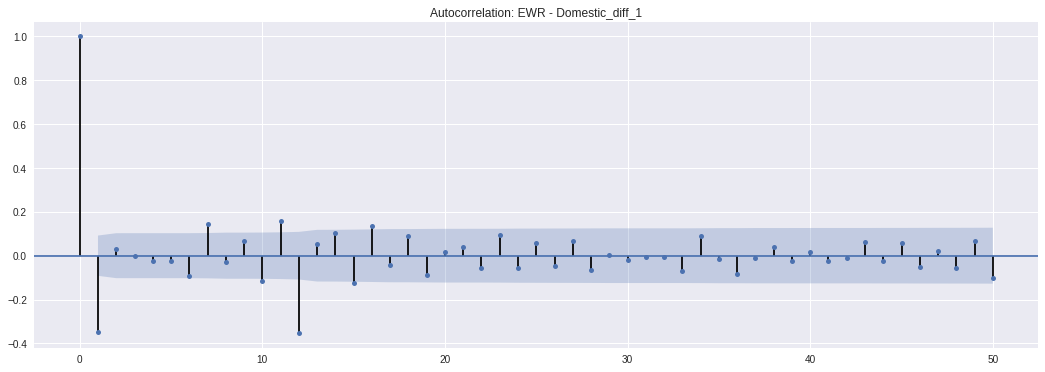

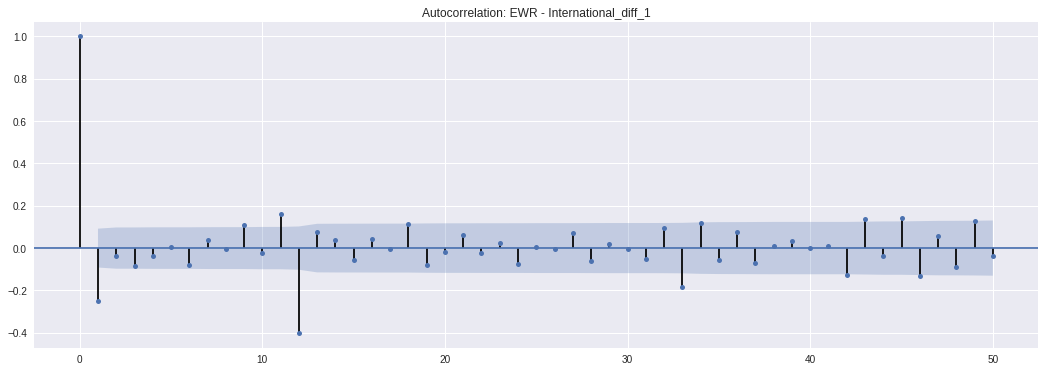

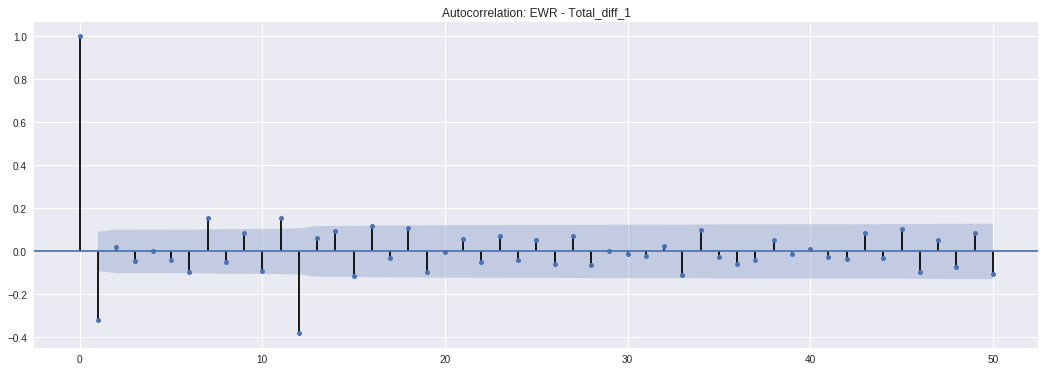

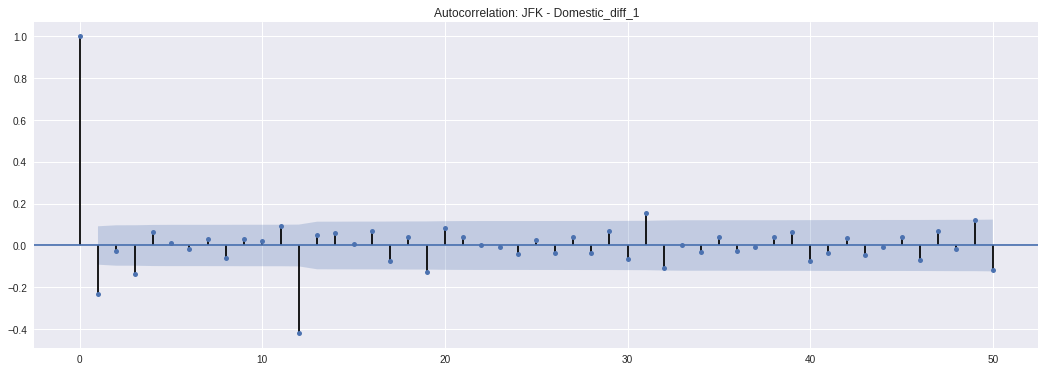

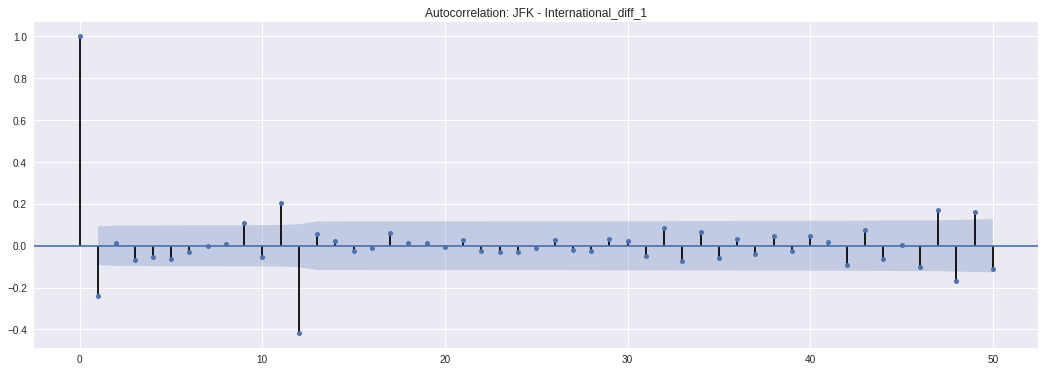

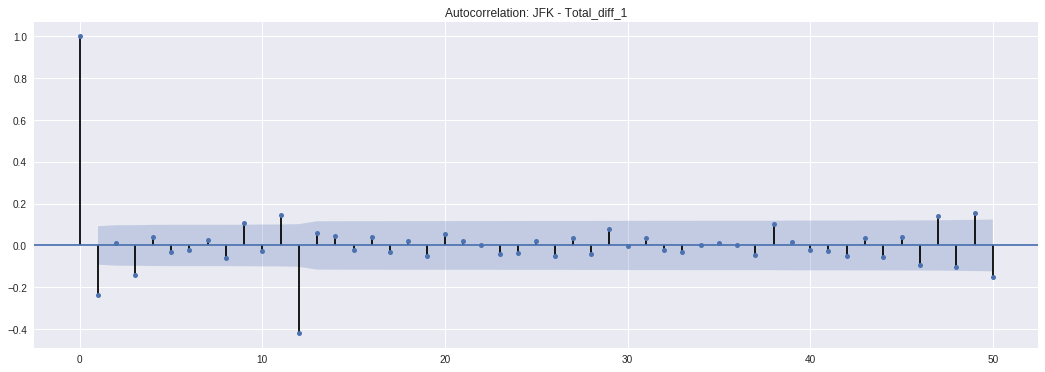

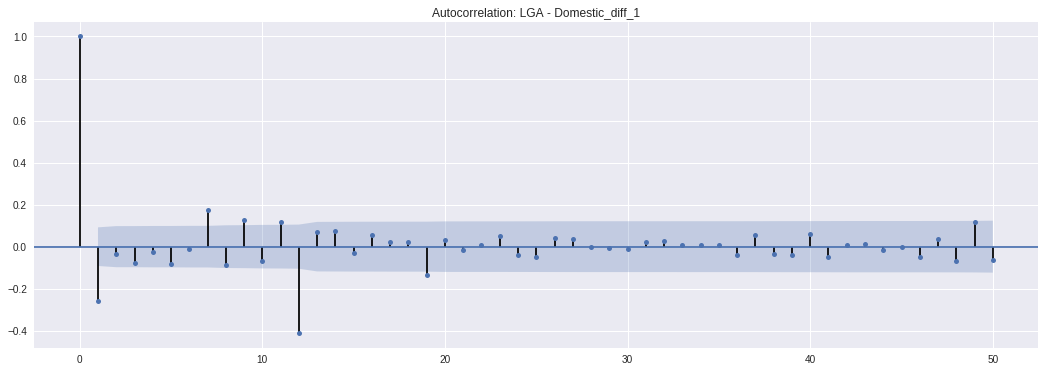

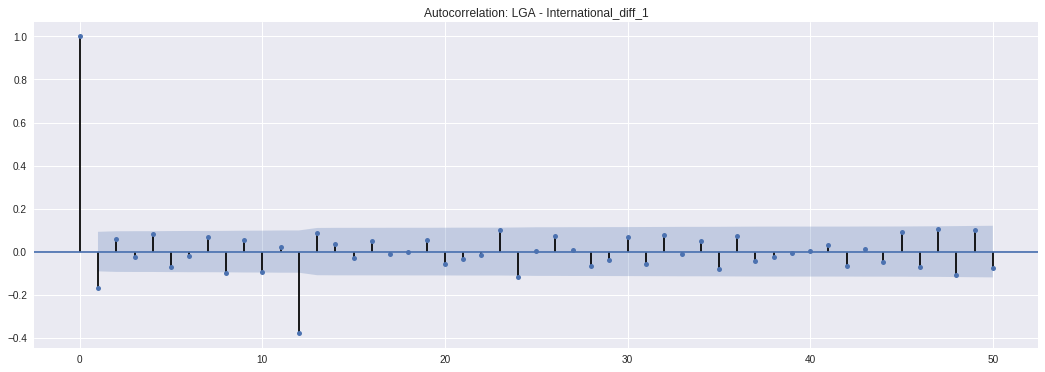

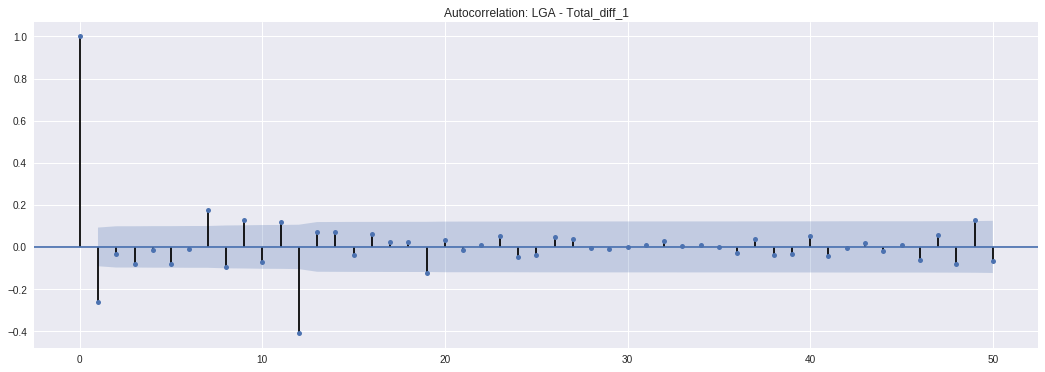

In [0]:
## Plotting ACF and PACF for determining AR, MA, SAR, SMA orders
## For the above differenced model: ARIMA (0,1,0)x(0,1,0)12
## ACF plots commonly show negative autocorrelations at lags 1 and 12; suggesting a MA characteristic, or might be a slight over-differencing

from statsmodels.graphics.tsaplots import plot_acf
plt.rcParams["figure.figsize"]=18,6
for x in range(3):
  for y in range(3):
    plot_acf(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+4], lags=50, 
             title='Autocorrelation: ' + str(code[x]) + ' - ' + str(df_3_airports.columns[y+4]))

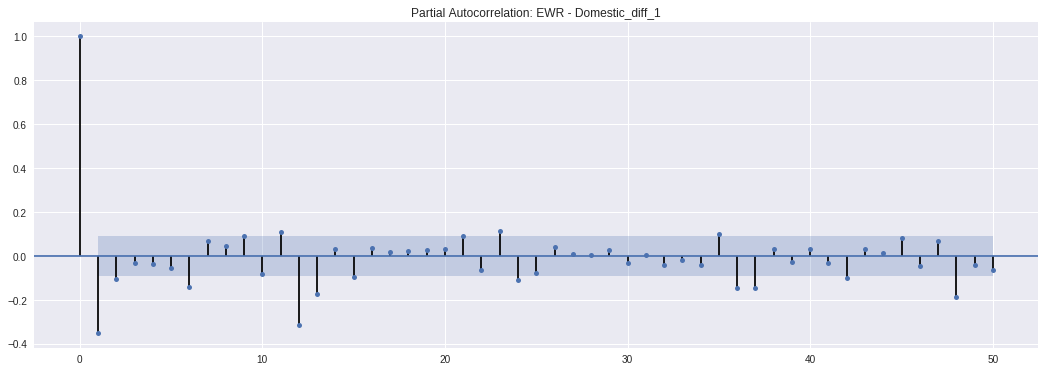

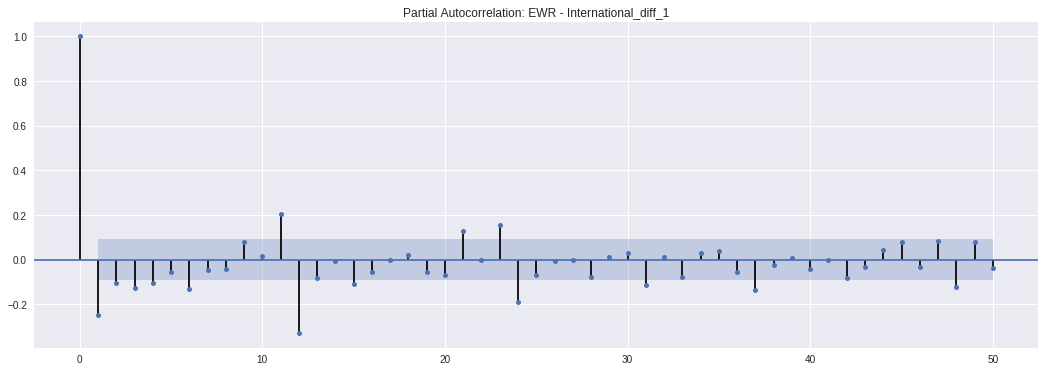

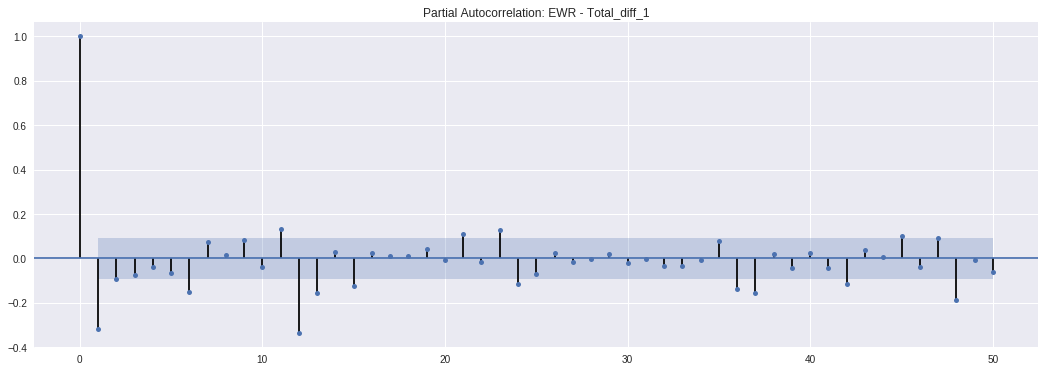

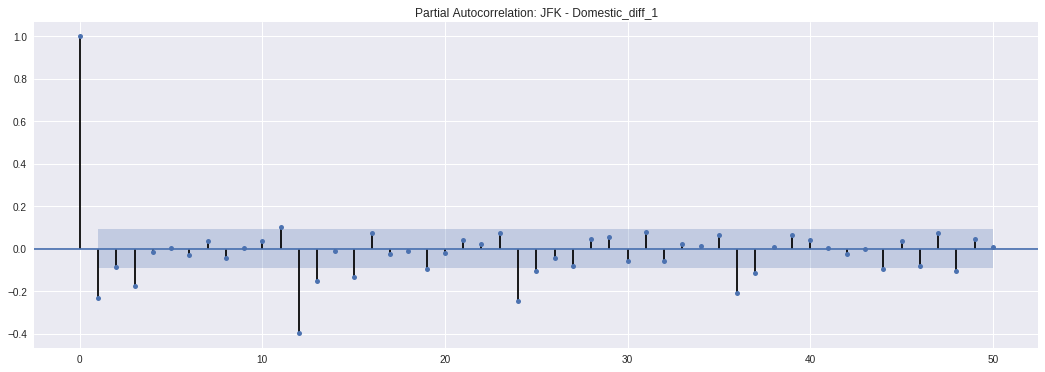

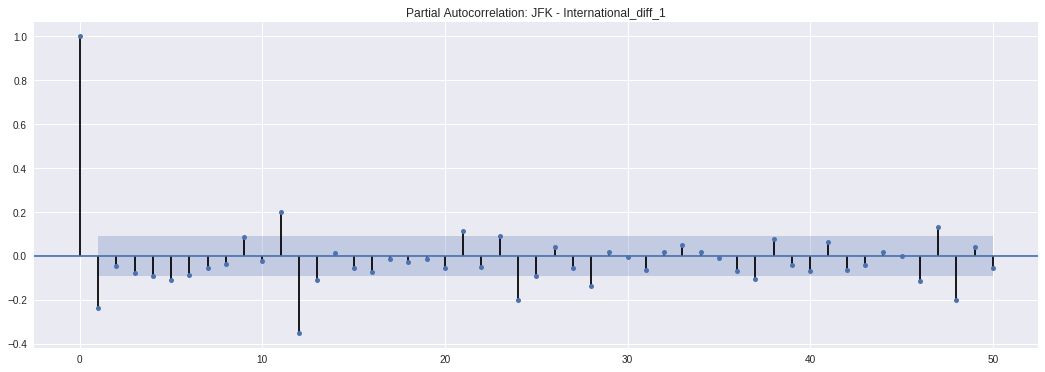

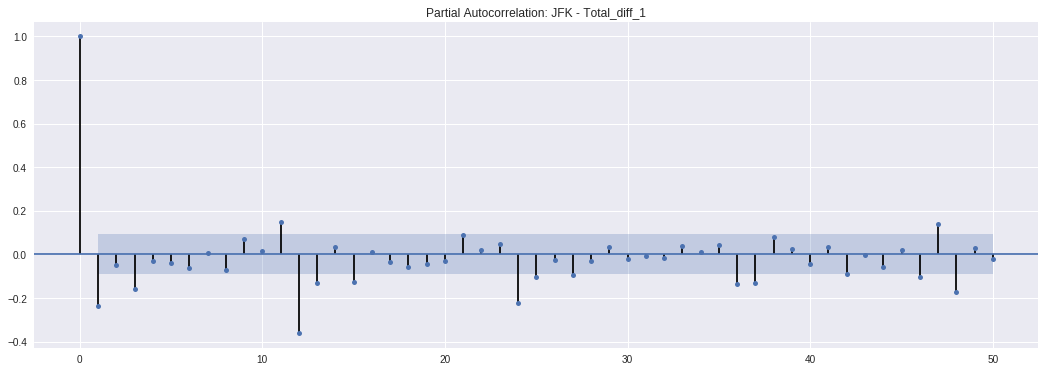

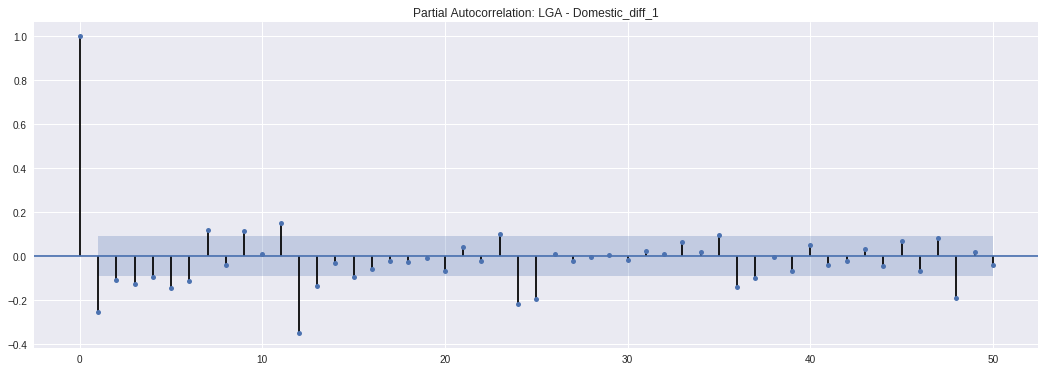

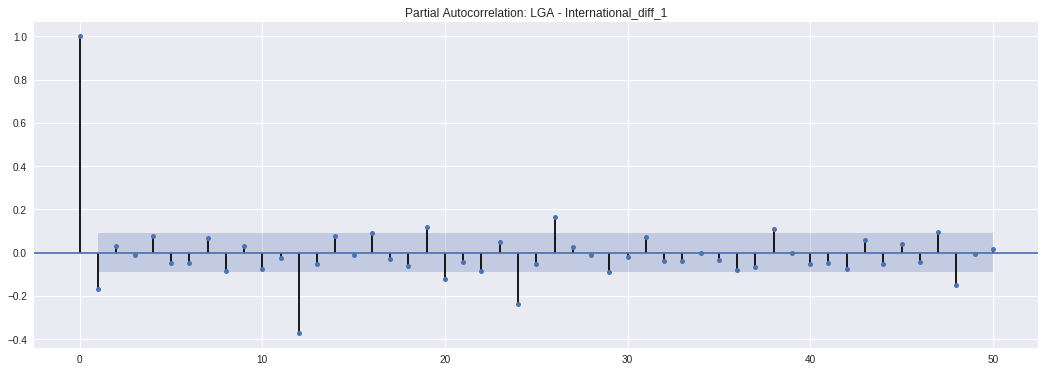

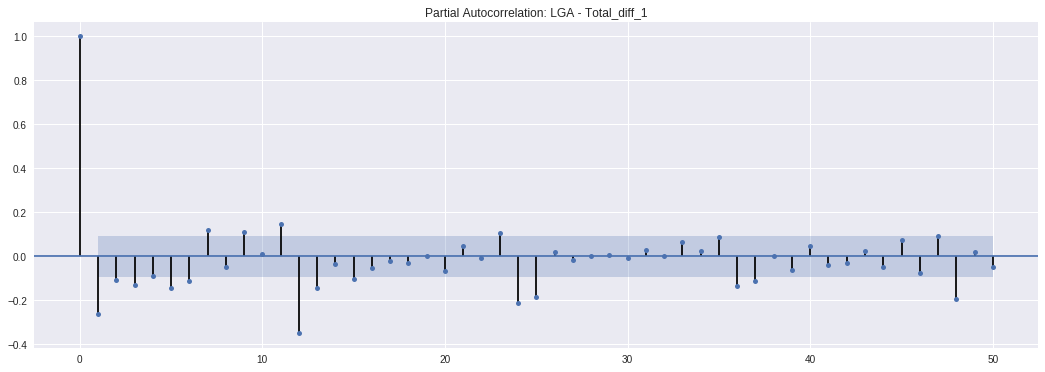

In [0]:
## For the above differenced model: ARIMA (0,1,0)x(0,1,0)12
## PACF plots commonly show negative autocorrelations mostly at lags 1 and 12; probably an ARIMA (0,1,1)x(0,1,1)12 would be a good try

from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams["figure.figsize"]=18,6
for x in range(3):
  for y in range(3):
    plot_pacf(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+4], lags=50,
             title='Partial Autocorrelation: ' + str(code[x]) + ' - ' + str(df_3_airports.columns[y+4]))

### Seasonal ARIMA tuning & predictions:

Greedily I reserved two sets of data of the most recent 12 months and 60 months for testing the predictability of my seasonal ARIMA model. 

Time series cross validation would be done splitting consecutive in chronological order. It can observed the last fold of cross validation had narrower training error than the first validation fold, as the model was taking in more and more observations as propagating through the time steps.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png' width="400"/>

Visualizing the results, the fitted model generally predicted quite well for the 12-month forecast. Except for EWR airport, it overestimated the international passengers, though it still could follow the changes in trend. For 60-month forecast, it was able to reconstruct some of the characterisitics in trends, surprisngly with a close fit to international passengers of the EWR airport and total passengers of the JFK airport. It could not capture abrupt boost of the number in long run, like the sudden increase observed in international passengers of the LGA airport. Overall, the model demonstrated a certain extent of predictive power. Yet of course, we could explore to increase the MA orders to see whether there would be improvements.



In [0]:
## import packages
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
## Cross-validation with time series split

def train_model(time_series, p, d, q, sp, sd, sq, lag):
  train_series = time_series[0:len(time_series)-60]
  test_series = time_series[-60:]
  
  tssp = TimeSeriesSplit(n_splits = 4)
  
  model = []
  y_pred = []
  y_actual = []
  validation_metric = []
  
  for train_index, test_index in tssp.split(train_series):
    ts_train = train_series[train_index]
    ts_valid = train_series[test_index]
  
    ts_model = SARIMAX(ts_train, order=(p,d,q), seasonal_order=(sp,sd,sq,lag))
    m = ts_model.fit()
    model.append(m)

    pred = m.forecast(steps=len(ts_valid))
    difference = np.array(pred) - np.array(ts_valid)
    percentage_variation = difference / np.array(ts_valid)
    validation_metric.append(percentage_variation)
    
    y_pred.append(pred)
    y_actual.append(ts_valid)

  return model, validation_metric, y_pred, y_actual

fitted_model = []
training_error = []
prediction = []
observation = []

for x in range(3):
  for y in range(3):
    arima, errors, results, observed = train_model(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1], 0, 1, 1, 0, 1, 1, 12)
    training_error.append(errors)
    fitted_model.append(arima)
    prediction.append(results)
    observation.append(observed)

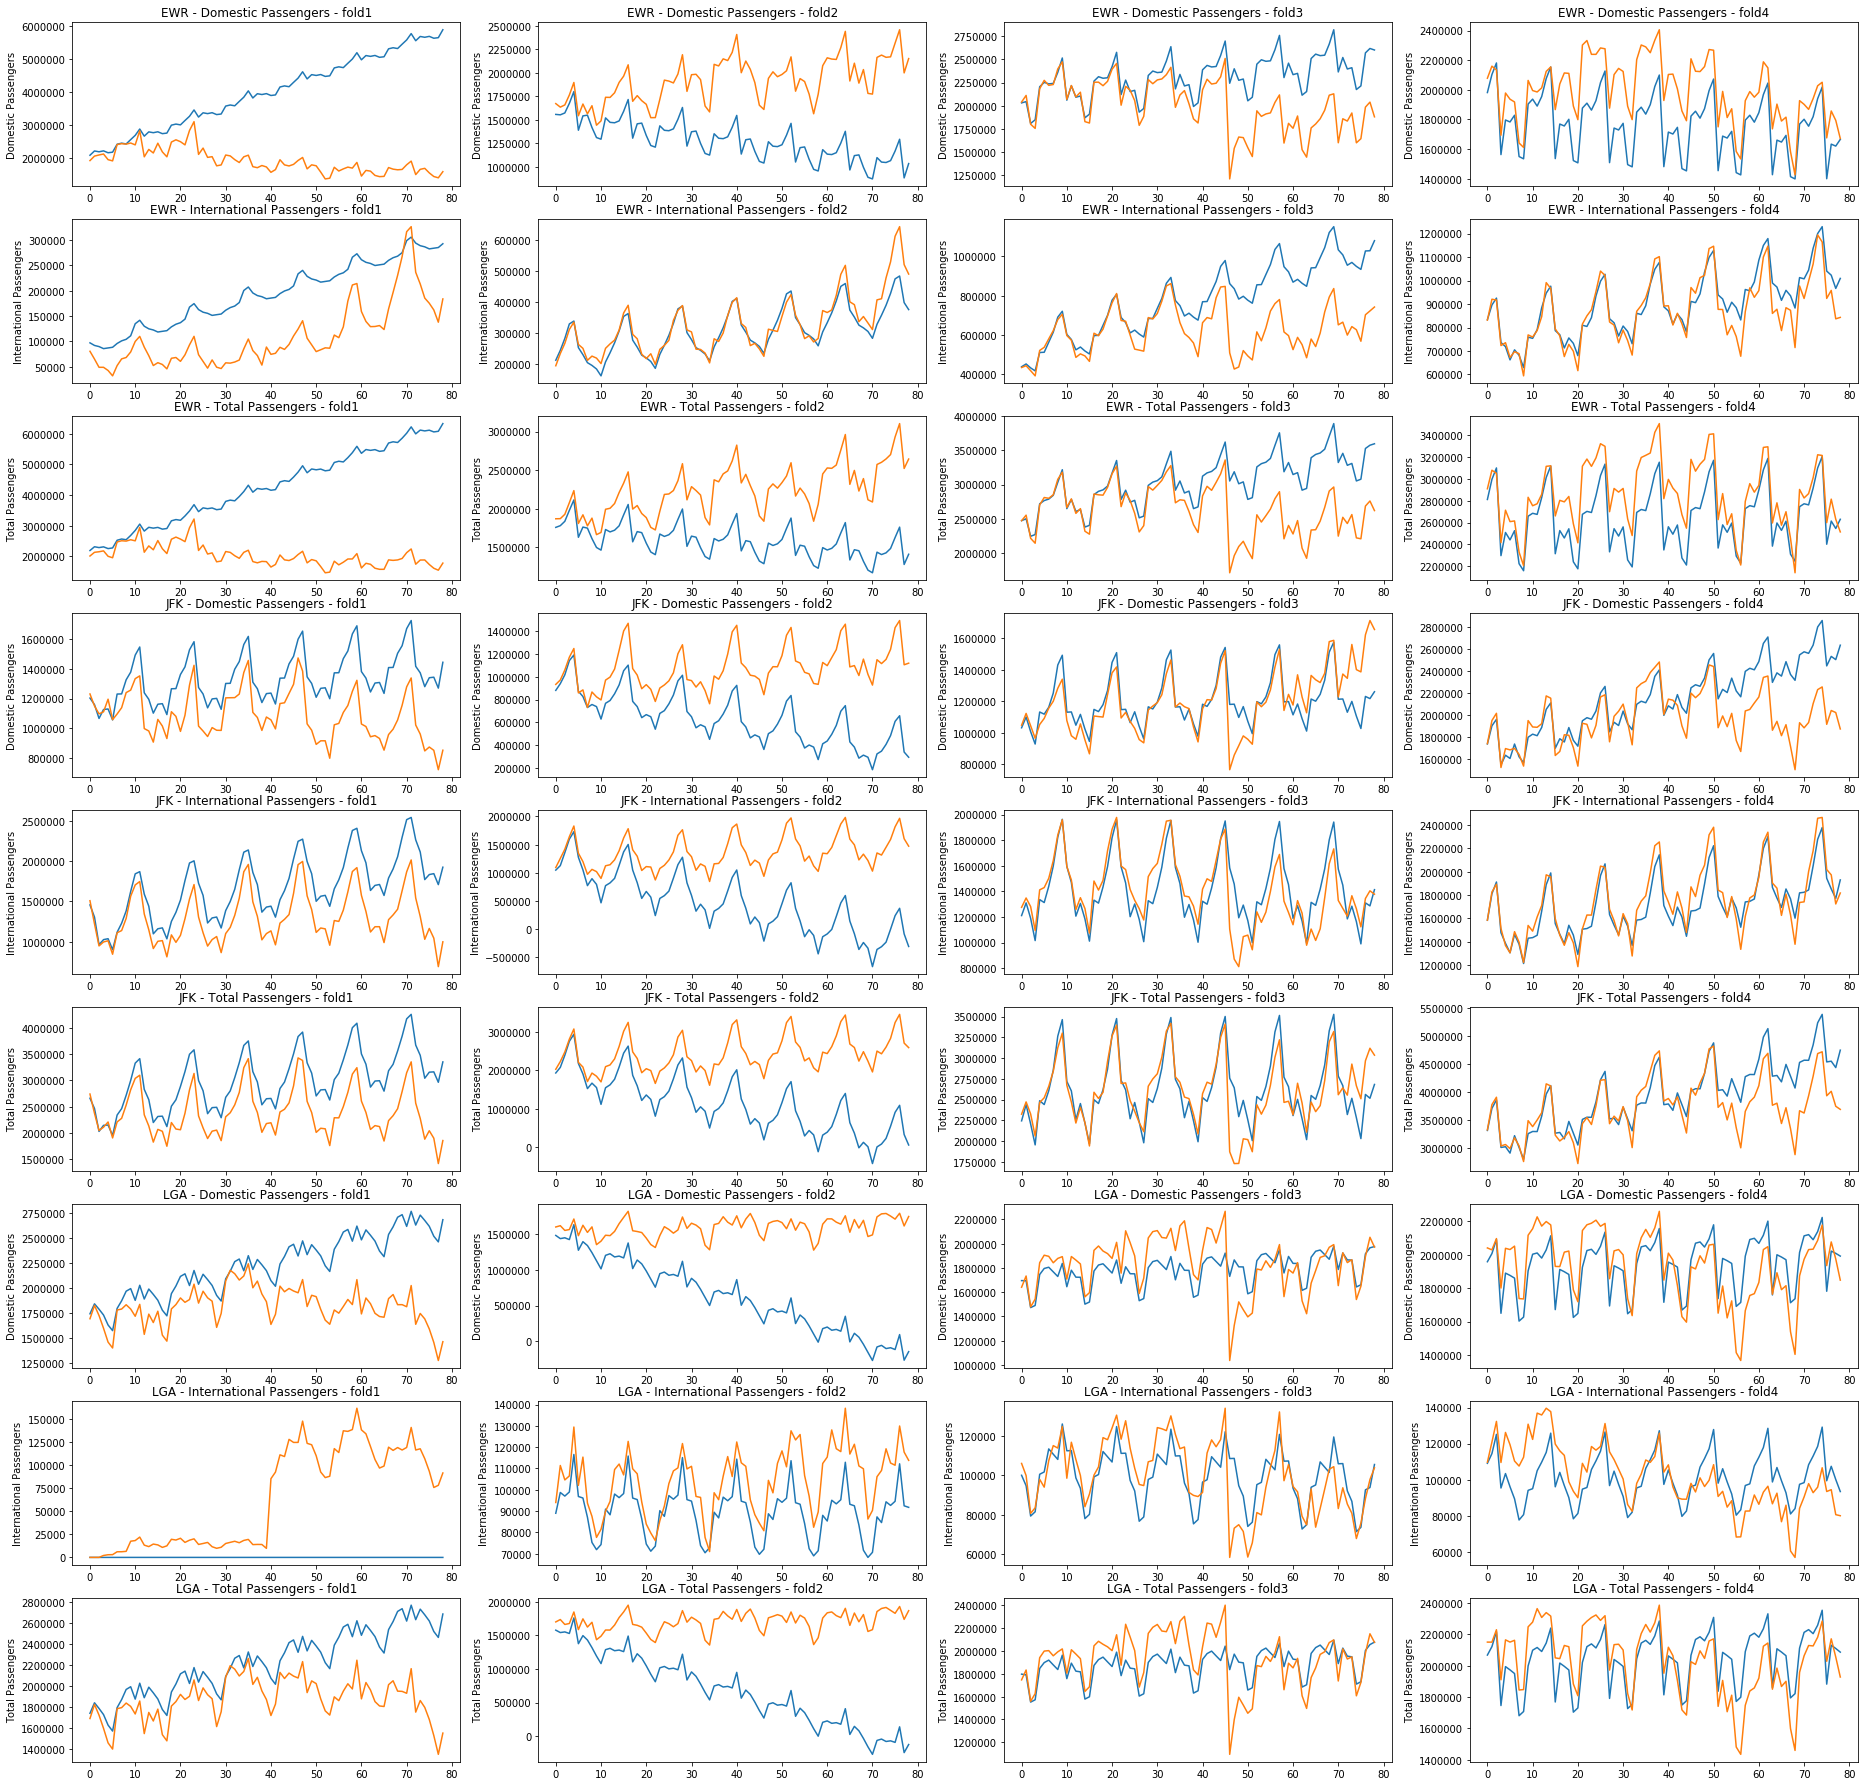

In [0]:
## Visulaize the training errors
## blue color line = predicted values
## orange color lines = actual observed values

fig, axes = plt.subplots(ncols=4, nrows=9, figsize = (32, 32))

for x in range(3):
  for y in range(3):
    for z in range(4):
      axes[x*3+y, z].set_title(str(code[x]) + " - " + str(df.columns[y+3]) + " - fold" + str(z+1))
      sb.lineplot(x=np.arange(len(training_error[x*3+y][z])), y=prediction[x*3+y][z], ax=axes[x*3+y, z])
      sb.lineplot(x=np.arange(len(training_error[x*3+y][z])), y=observation[x*3+y][z], ax=axes[x*3+y, z])

In [0]:
## Predict on testing data (one year)

list_model = []
list_predict = []
list_actual = []
list_validation_metric = []

for x in range(3):
  for y in range(3):
    Set_model = SARIMAX(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1][0:len(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1])-12], 
                        order=(0,1,1), seasonal_order=(0,1,1,12))
    time_model = Set_model.fit()

    fcst = time_model.forecast(steps=12)
    y_difference = np.array(fcst) - np.array(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1][-12:])
    y_percentage_variation = y_difference / np.array(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1][-12:])
    
    list_model.append(Set_model)
    list_predict.append(fcst)
    list_actual.append(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1][-12:])
    list_validation_metric.append(y_percentage_variation)

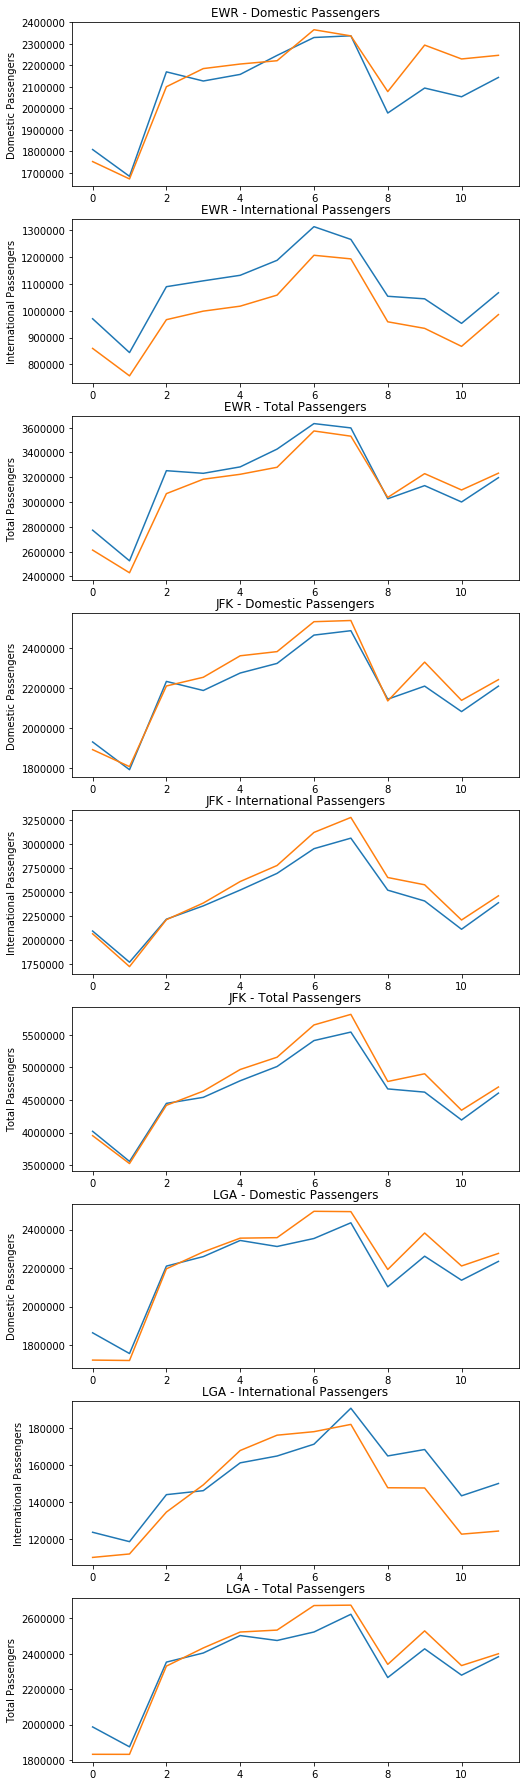

In [0]:
fig, axes = plt.subplots(ncols=1, nrows=9, figsize = (8, 32))

for x in range(3):
  for y in range(3):
    axes[x*3+y].set_title(str(code[x]) + " - " + str(df.columns[y+3]))
    sb.lineplot(x=np.arange(12), y=list_predict[x*3+y], ax=axes[x*3+y])
    sb.lineplot(x=np.arange(12), y=list_actual[x*3+y], ax=axes[x*3+y])

In [0]:
## Try to forecast 5 year cycle
list_model2 = []
list_predict2 = []
list_actual2 = []
list_validation_metric2 = []

for x in range(3):
  for y in range(3):
    Set_model2 = SARIMAX(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1][0:len(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1])-60], 
                        order=(0,1,1), seasonal_order=(0,1,1,12))
    time_model2 = Set_model2.fit()

    fcst2 = time_model2.forecast(steps=60)
    y_difference2 = np.array(fcst2) - np.array(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1][-60:])
    y_percentage_variation2 = y_difference2 / np.array(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1][-60:])
    
    list_model2.append(Set_model2)
    list_predict2.append(fcst2)
    list_actual2.append(df_3_airports[df_3_airports['Airport Code']==code[x]].iloc[:,y+1][-60:])
    list_validation_metric2.append(y_percentage_variation2)

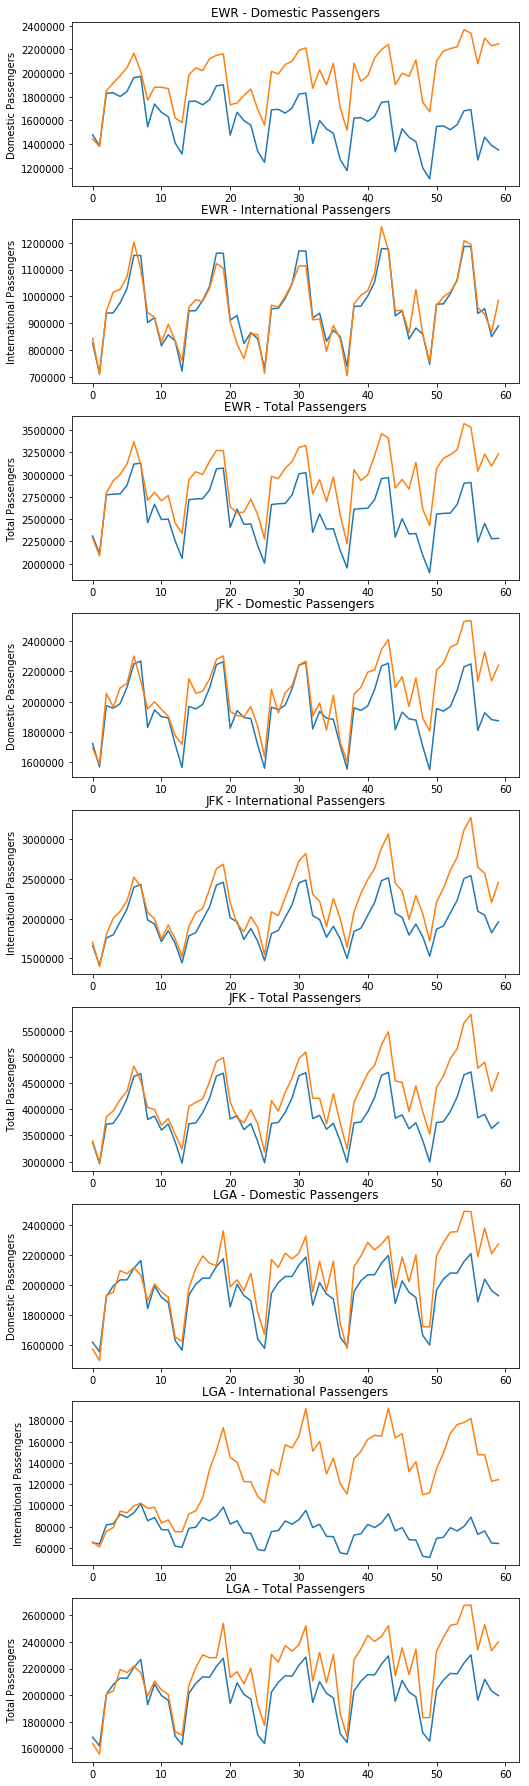

In [0]:
fig, axes = plt.subplots(ncols=1, nrows=9, figsize = (8, 32))

for x in range(3):
  for y in range(3):
    axes[x*3+y].set_title(str(code[x]) + " - " + str(df.columns[y+3]))
    sb.lineplot(x=np.arange(60), y=list_predict2[x*3+y], ax=axes[x*3+y])
    sb.lineplot(x=np.arange(60), y=list_actual2[x*3+y], ax=axes[x*3+y])